In [798]:
# Importar as libs necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree
from sklearn.cluster import KMeans, DBSCAN, MeanShift

from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering

# Outros
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
import plotly.graph_objects as go
from scipy.stats import zscore
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer

### Data Understanding: 

In [799]:
class DataUnderstanding():
    def verificando_as_dimensões_do_dataframe(self, dataframe: pd.DataFrame):
        dataframe = dataframe.shape
        print(f'Linhas: {dataframe[0]} \nColunas: {dataframe[1]}')

    def descrição(self, dataframe: pd.DataFrame):
        dataframe = dataframe.describe([.25, .50, .75, .99]).round(decimals=2)
        return dataframe

    def verificando_tipos(self, dataframe: pd.DataFrame):
        dataframe = (
            dataframe.dtypes
            .to_frame('Tipos')
        )
        return dataframe

    def verificando_valores_nulos(self, dataframe: pd.DataFrame):
        valores_nulos = dataframe.isnull().sum()
        percent_missing = (valores_nulos / len(dataframe))
        dataframe = pd.DataFrame(
            {
                'Quantidade': valores_nulos,
                'Porcentagem': percent_missing
            }
        )
        dataframe = dataframe.style.format('{:.2%}', subset=['Porcentagem'])
        return dataframe

    def verificando_valores_duplicados(self, dataframe: pd.DataFrame):
        valores_repetidos = dataframe.apply(lambda x: x.duplicated()).sum()
        percent_missing = (valores_repetidos / len(dataframe))
        dataframe = pd.DataFrame(
            {
                'Quantidade': valores_repetidos,
                'Porcentagem': percent_missing
            },
            index=dataframe.columns
        )

        dataframe = dataframe.style.format('{:.2%}', subset=['Porcentagem'])
        return dataframe

    def frequencia_da_repetição_dos_valores(self, dataframe: pd.DataFrame, coluna: str):
        dataframe = dataframe[coluna].value_counts().reset_index()
        return dataframe

    def verificando_correlação(self, dataframe: pd.DataFrame):
        dataframe = dataframe.corr()
        return dataframe


if __name__ == '__main__':
    data_understanding = DataUnderstanding()

### Data Preparetion:

In [800]:
class DataPreparetion(DataUnderstanding):
    def removendo_nulos(self, dataframe: pd.DataFrame) -> pd.DataFrame:
        return dataframe.dropna()

    def removing_outliers_zscore(self, dataframe: pd.DataFrame, column: list, threshold: int=3):
        z_scores = np.abs(zscore(dataframe[column]))
        outlier_indices = np.where(z_scores > threshold)[0]
        outlier_labels = dataframe.index[outlier_indices]
        dataframe_cleaned = dataframe.drop(outlier_labels)
        print(f'Amount of outliers: {len(outlier_indices)}')
        return dataframe_cleaned


    def removendo_colunas(self, dataframe: pd.DataFrame, colunas=[]) -> pd.DataFrame:
        return dataframe.drop(colunas, axis=1)

    def renomeando_colunas(self, dataframe: pd.DataFrame, novo_nome_e_velho_nome: dict):
        return dataframe.rename(columns=novo_nome_e_velho_nome)

    def substituindo_valores(self, dataframe: pd.DataFrame, colunas, valores) -> pd.DataFrame:
        return dataframe[colunas].replace(valores)

    def convertendo_colunas(self, dataframe: pd.DataFrame, colunas: list, tipo: str) -> pd.DataFrame:
        return dataframe[colunas].astype(tipo)

    def dummy(self, dataframe: pd.DataFrame, colunas=[]):
        dataframe = pd.get_dummies(dataframe[colunas])
        colunas = dataframe.columns
        return dataframe, colunas

    def label_endcode(self, dataframe: pd.DataFrame):
        training = LabelEncoder().fit(dataframe)
        dataframe = training.transform(dataframe)
        return dataframe

    def normalizando_os_dados(self, dataframe: pd.DataFrame):
        return scale(dataframe)


if __name__ == '__main__':
    data_preparetion = DataPreparetion()

### Data Visualization:

In [801]:
class DataVisualization(DataPreparetion):
    def __init__(self) -> None:
        sns.set_theme(
            context='talk',
            style='ticks',
            font_scale=.8,
            palette='tab10',
            rc={
                'figure.figsize': (12, 8),
                'axes.grid': True,
                'grid.alpha': .2,
                'axes.titlesize': 'x-large',
                'axes.titleweight': 'bold',
                'axes.titlepad': 20,
            }
        )

        self.scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

    def gráfico_barplot(self, dataframe: pd.DataFrame, x: str, y: str):
        sns.barplot(
            data=dataframe,
            x=x,
            y=y
        )
        plt.show()

    def gráfico_pairplot(self, dataframe: pd.DataFrame):
        sns.pairplot(dataframe)
        plt.show()

    def gráfico_heatmap(self, dataframe: pd.DataFrame):
        sns.set(style='white')
        corr = dataframe.corr()
        plt.figure(figsize=(16, 10))
        sns.heatmap(
            corr, annot=True, cmap='RdBu_r', fmt='.2f', annot_kws={'size': 12}
        )
        plt.show()

    def gráfico_boxplot(self, dataframe: pd.DataFrame, figsize: tuple):
        dataframe = dataframe.select_dtypes(include='number')
        dataframe = dataframe.apply(scale)
        fig = plt.figure(figsize=figsize)
        sns.boxplot(data=dataframe)
        plt.xticks(rotation=60, ha='right')
        plt.show()

    def gráfico_histplot(self, dataframe: pd.DataFrame, coluna: str):
        sns.histplot(data=dataframe[coluna])
        plt.xticks(rotation=60, ha='right')
        plt.show()

    def gráfico_scatterplot(self, dataframe: pd.DataFrame, x:str, y:str, hue:list, titulo: str=''):
        sns.scatterplot(data=dataframe, x=x, y=y, hue=hue)
        plt.title(titulo)
        plt.show()


if __name__ == '__main__':
    data_visualization = DataVisualization()

# Agrupando perfis de clientes para tomar decisões de fidelização:

## DataFrame:

In [802]:
path = r'../../../data/ecommerce.csv'
df = pd.read_csv(
    filepath_or_buffer=path,
    encoding='unicode_escape',
    decimal='.',
    sep=';'
)

In [803]:
display(df.tail())

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
25827,581583,LUNCH BAG RED RETROSPOT,14/06/2022 12:23,40,1.45,13777.0,14/06/2022
25828,581584,RED FLOCK LOVE HEART PHOTO FRAME,14/06/2022 12:25,72,0.72,13777.0,14/06/2022
25829,581585,BLACK TEA TOWEL CLASSIC DESIGN,14/06/2022 12:31,12,0.39,15804.0,14/06/2022
25830,581586,LARGE CAKE STAND HANGING STRAWBERY,14/06/2022 12:49,8,2.95,13113.0,14/06/2022
25831,581587,CIRCUS PARADE LUNCH BOX,14/06/2022 12:50,12,1.95,12680.0,14/06/2022


## Código:

In [804]:
class AgrupandoPerfisDeClientes(DataVisualization):
    def gráfico_kelbow_visualizer(self, modelo, x, k: int):
        return kelbow_visualizer(modelo, x, k=k, timings=False)
    
    def clustering_k_means(self, model, x):
        model.fit(x)
        centroids = model.cluster_centers_
        labels = model.labels_
        inertia = model.inertia_
        predict = model.fit_predict(x)
        return centroids, labels, inertia, predict

    def gráfico_clusters_scatterplot3d(self, data: list, labels, figsize: tuple, titulo: str):
        plt.figure(figsize=figsize)
        plt.title(titulo)
        ax = plt.axes(projection='3d')
        fg = ax.scatter3D(data[0], data[1], data[2], s=60, c = labels,)

    def gráfico_clusters_scatterplot3d_interativo(self, data, labels, figsize, titulo):
        fig = go.Figure(data=[go.Scatter3d(
            x=data[0],
            y=data[1],
            z=data[2],
            mode='markers',
            marker=dict(
                size=6,
                color=labels,
                colorscale='Viridis',
                opacity=0.8
            )
        )])

        fig.update_layout(
            title=titulo,
            width=figsize[0],
            height=figsize[1],
            scene=dict(
                xaxis=dict(title='Eixo X'),
                yaxis=dict(title='Eixo Y'),
                zaxis=dict(title='Eixo Z')
            )
        )

        fig.show()

if __name__ == '__main__':
    agrupando_perfis_de_clientes = AgrupandoPerfisDeClientes()

## Output:

### Data Understanding:

In [805]:
display(df.head(3))

,id_pedido,descricao,data_pgto,quantidade,preco_unitario,id_cliente,ultima_compra
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,06/06/2021 08:26,6,2.55,17850.0,16/08/2021
1,536366,HAND WARMER UNION JACK,06/06/2021 08:28,6,1.85,17850.0,16/08/2021
2,536367,ASSORTED COLOUR BIRD ORNAMENT,06/06/2021 08:34,32,1.69,13047.0,14/05/2022


In [806]:
df.columns

Index(['id_pedido', 'descricao', 'data_pgto', 'quantidade', 'preco_unitario',
       'id_cliente', 'ultima_compra'],
      dtype='object')

In [847]:
agrupando_perfis_de_clientes.verificando_as_dimensões_do_dataframe(
    dataframe=df,
)

Linhas: 22190 
Colunas: 8


In [808]:
agrupando_perfis_de_clientes.descrição(
    dataframe=df
)

,quantidade,preco_unitario,id_cliente
count,25832.00,25832.00,22190.00
mean,19.34,21.94,15238.50
std,29.46,434.44,1733.15
min,1.00,-11062.06,12346.00
25%,2.00,1.06,13755.00
50%,8.00,2.08,15136.00
75%,24.00,4.95,16746.00
99%,144.00,125.00,18224.11
max,151.00,38970.00,18287.00


In [809]:
agrupando_perfis_de_clientes.verificando_tipos(
    dataframe=df
)

,Tipos
id_pedido,object
descricao,object
data_pgto,object
quantidade,int64
preco_unitario,float64
id_cliente,float64
ultima_compra,object


In [810]:
agrupando_perfis_de_clientes.verificando_valores_nulos(
    dataframe=df
)

,Quantidade,Porcentagem
id_pedido,0,0.00%
descricao,1454,5.63%
data_pgto,0,0.00%
quantidade,0,0.00%
preco_unitario,0,0.00%
id_cliente,3642,14.10%
ultima_compra,0,0.00%


In [811]:
agrupando_perfis_de_clientes.verificando_valores_duplicados(
    dataframe=df
)

,Quantidade,Porcentagem
id_pedido,0,0.00%
descricao,22828,88.37%
data_pgto,2655,10.28%
quantidade,25695,99.47%
preco_unitario,25199,97.55%
id_cliente,21459,83.07%
ultima_compra,25527,98.82%


In [812]:
agrupando_perfis_de_clientes.frequencia_da_repetição_dos_valores(
    dataframe=df,
    coluna='ultima_compra'
)

,index,ultima_compra
0,#N/D,3642
1,13/06/2022,2156
2,11/06/2022,1325
3,12/06/2022,1317
4,14/06/2022,994
...,...,...
300,09/09/2021,1
301,24/06/2021,1
302,26/08/2021,1
303,10/07/2021,1


### Data Preparetion:

In [813]:
df_copy = df.copy()

Removendo valores nulos:

In [814]:
df = agrupando_perfis_de_clientes.removendo_nulos(
    dataframe=df,
)

Convertendo a coluna 'id_cliente' para str:

In [815]:
colunas = ['id_cliente', 'id_pedido']

In [816]:
df[colunas] = agrupando_perfis_de_clientes.convertendo_colunas(
    dataframe=df,
    colunas=colunas,
    tipo='str'
)

Convertendo a coluna 'ultima_compra' para Datetime:

In [817]:
df['ultima_compra'] = pd.to_datetime(
    arg=df['ultima_compra'],
    format='%d/%m/%Y'
)

Convertendo a coluna 'data_pgto' para Datetime:

In [818]:
df['data_pgto'] = pd.to_datetime(
    arg=df['data_pgto'],
    format='%d/%m/%Y %H:%M'
)

### Análise RFV:

A sigla RFV significa Recency, Frequency, and Monetary Value, que são três métricas utilizadas para análise de clientes em estratégias de marketing.

- Recency (Recência) mede o tempo decorrido desde a última interação do cliente com a empresa, como uma compra ou uma visita ao site. Clientes mais recentes podem ter maior probabilidade de responder a promoções ou ofertas.

- Frequency (Frequência) indica a frequência com que um cliente realiza transações ou interações com a empresa em um determinado período de tempo. Clientes mais frequentes podem ser considerados mais engajados e valiosos.

- Monetary Value (Valor Monetário) representa o valor total gasto por um cliente em um determinado período. Clientes de alto valor monetário podem ser segmentados de forma diferente e receber um tratamento especial.


#### Recency:

Obtendo a data mais recente presente no dataframe:

In [819]:
data_mais_recente = df['data_pgto'].max()

In [820]:
display(data_mais_recente)

Timestamp('2022-06-14 12:50:00')

Calculando a recência em dias:

In [821]:
df_recency = df.groupby('id_cliente')['data_pgto'].max().reset_index()
df_recency['Recency'] = (data_mais_recente - df_recency['data_pgto']).dt.days
df_recency = df_recency.drop('data_pgto', axis=1)

In [822]:
display(df_recency.head(3))

,id_cliente,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74


Frequency:

In [823]:
df_frequency = df.groupby('id_cliente').agg({'data_pgto': 'count'}).reset_index()
df_frequency = df_frequency.rename(columns={'data_pgto': 'Frequency'})

In [824]:
display(df_frequency.head(3))

,id_cliente,Frequency
0,12346.0,2
1,12347.0,7
2,12348.0,4


Monetary value:

In [825]:
df_monetary_value = df
df_monetary_value['MonetaryValue'] = df['quantidade'] * df['preco_unitario']
df_monetary_value = df_monetary_value.groupby('id_cliente').agg({'MonetaryValue': 'sum'}).reset_index()

In [826]:
display(df_monetary_value.head(3))

,id_cliente,MonetaryValue
0,12346.0,28.08
1,12347.0,163.16
2,12348.0,331.36


**RFV:**

Merge:

In [827]:
df_rfv = pd.merge(df_recency, df_frequency, on='id_cliente', how='inner')
df_rfv = pd.merge(df_rfv, df_monetary_value, on='id_cliente', how='inner')

### Data Visualization:

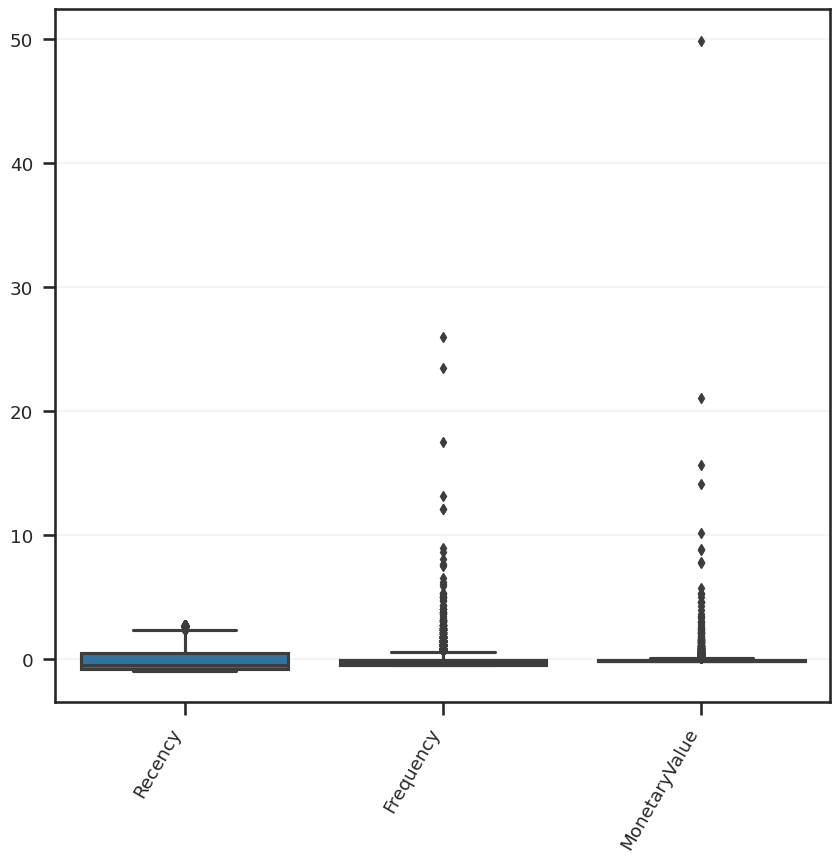

In [828]:
agrupando_perfis_de_clientes.gráfico_boxplot(
    dataframe=df_rfv,
    figsize=(10, 9)
)

In [829]:
colunas = ['Recency', 'Frequency', 'MonetaryValue']

Recency:


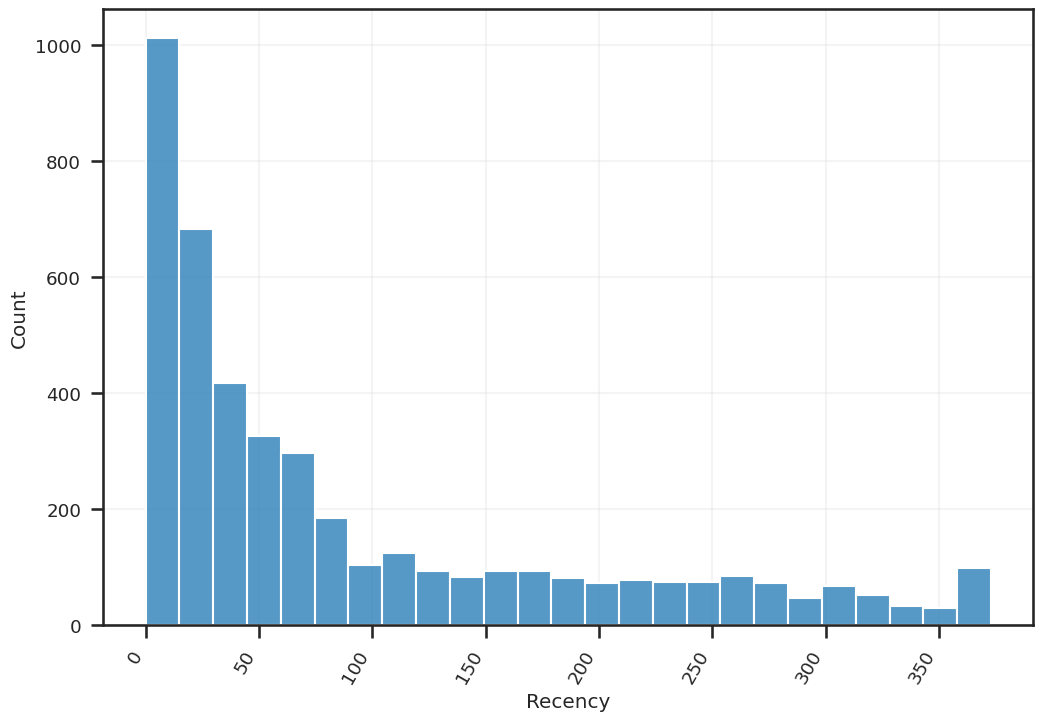

Frequency:


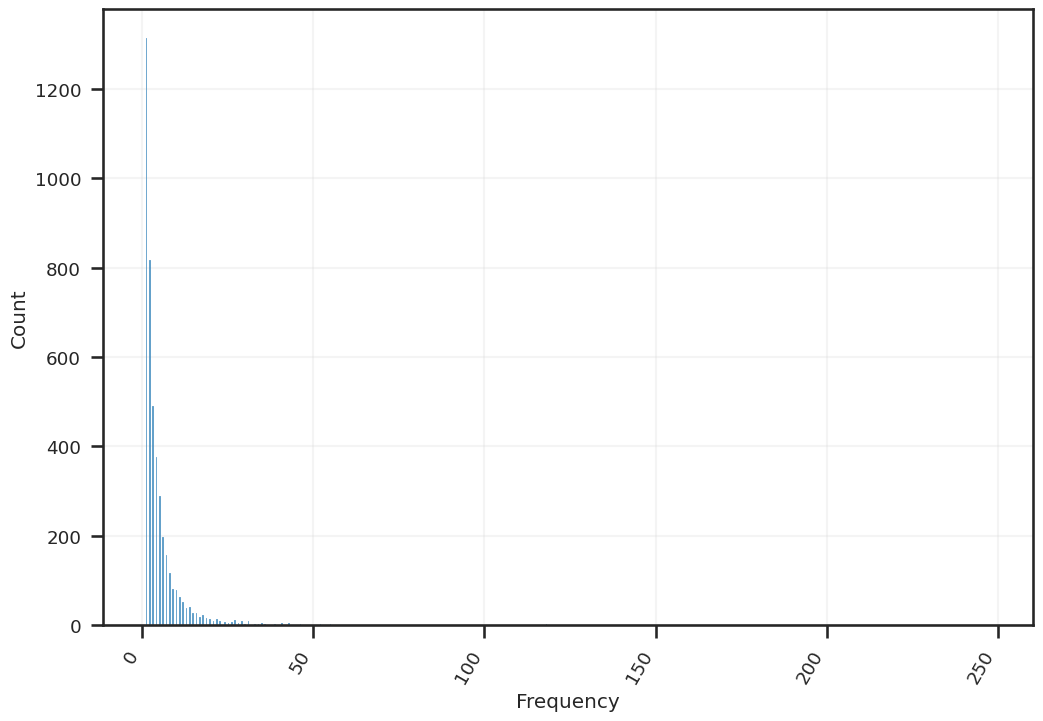

MonetaryValue:


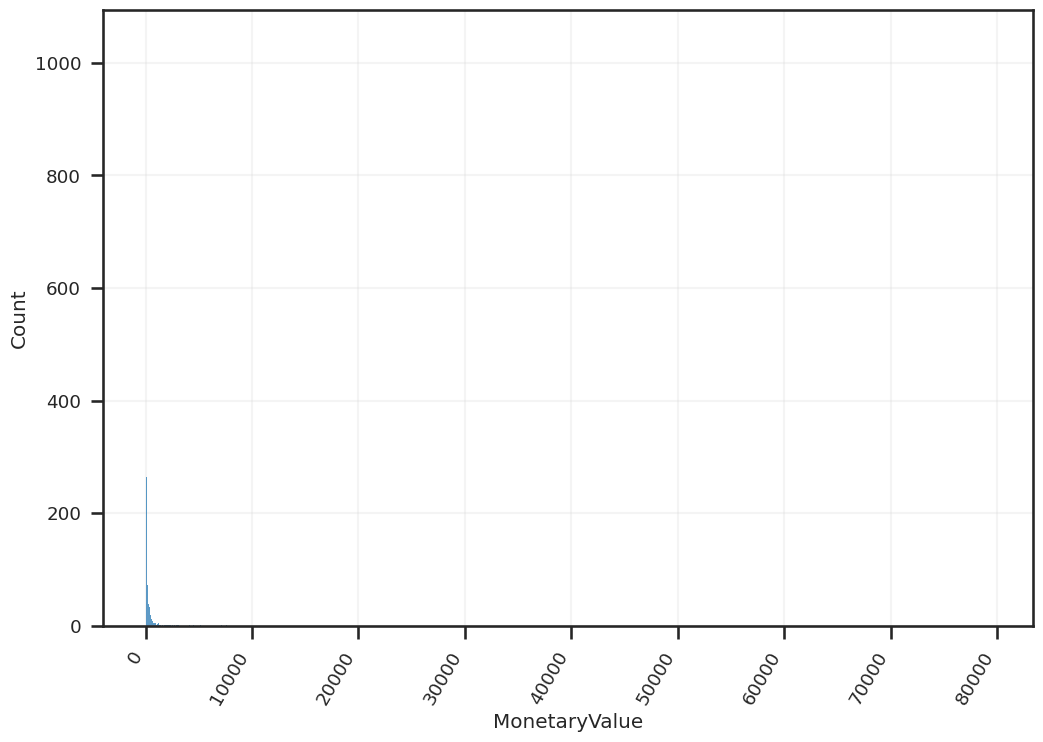

In [830]:


for coluna in colunas:
    print(f'{coluna}:')
    agrupando_perfis_de_clientes.gráfico_histplot(
        dataframe=df_rfv,
        coluna=coluna
)

In [831]:
# agrupando_perfis_de_clientes.gráfico_histplot(
#     dataframe=df,
#     coluna='preco_unitario'
# )

### Data Preparetion:

Colunas númericas:

In [832]:
colunas = ['Recency', 'Frequency', 'MonetaryValue']

Normalizando os dados:

In [833]:
for coluna in colunas:
    df_rfv[coluna] = agrupando_perfis_de_clientes.normalizando_os_dados(
        dataframe=df_rfv[coluna]
    )

Removendo nulos:

In [834]:
df_rfv = agrupando_perfis_de_clientes.removendo_nulos(
    dataframe=df_rfv
)

Removendo outliers:

In [835]:
def remove_outliers_iqr(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR
    df_sem_outliers = df[(df[coluna] >= limite_inferior) & (df[coluna] <= limite_superior)]
    return df_sem_outliers[coluna]

for coluna in colunas:
    print(coluna)
    df_rfv[coluna] = remove_outliers_iqr(df=df_rfv, coluna=coluna)

Recency
Frequency
MonetaryValue


In [836]:
df_rfv = agrupando_perfis_de_clientes.removendo_nulos(
    dataframe=df_rfv
)

### Data Visualization:

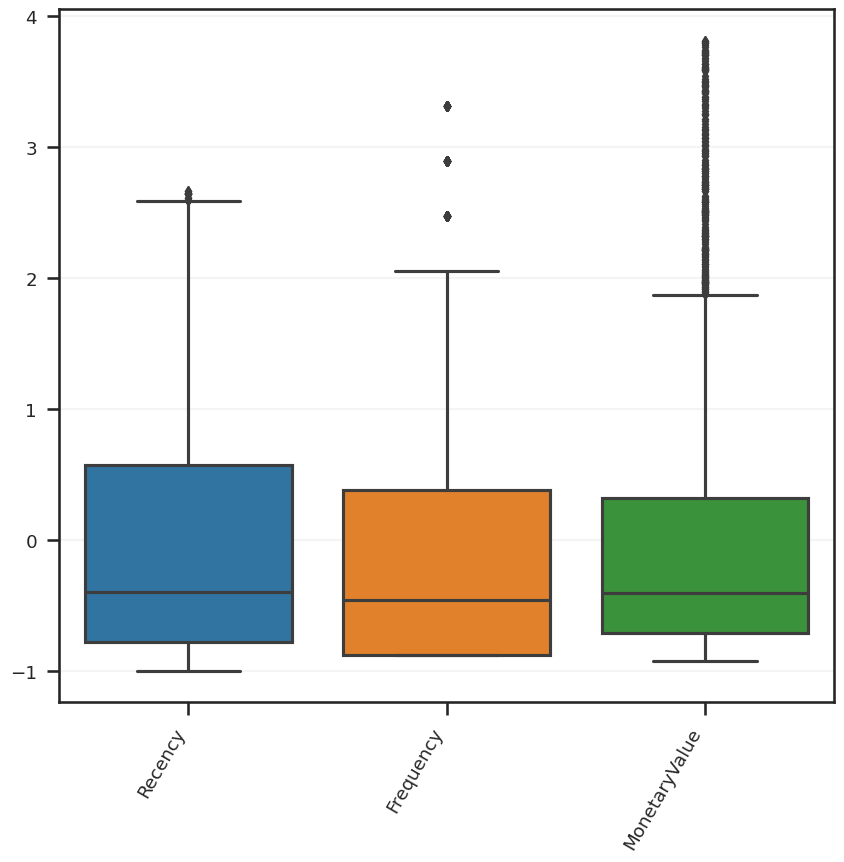

In [837]:
agrupando_perfis_de_clientes.gráfico_boxplot(
    dataframe=df_rfv,
    figsize=(10, 9)
)

Recency:


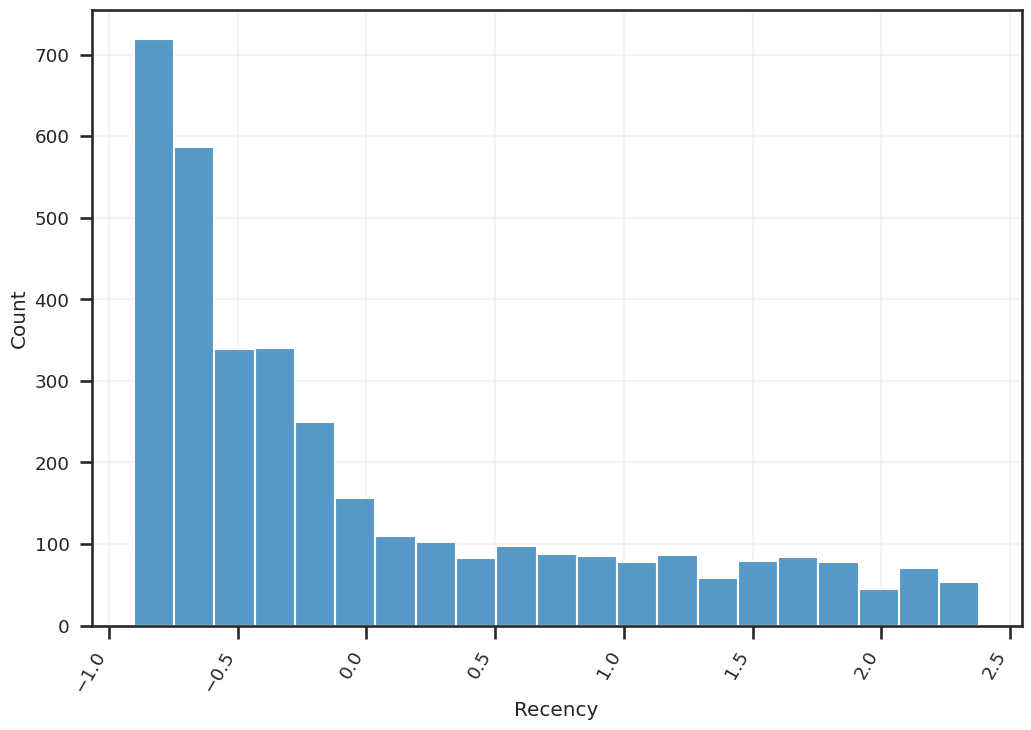

Frequency:


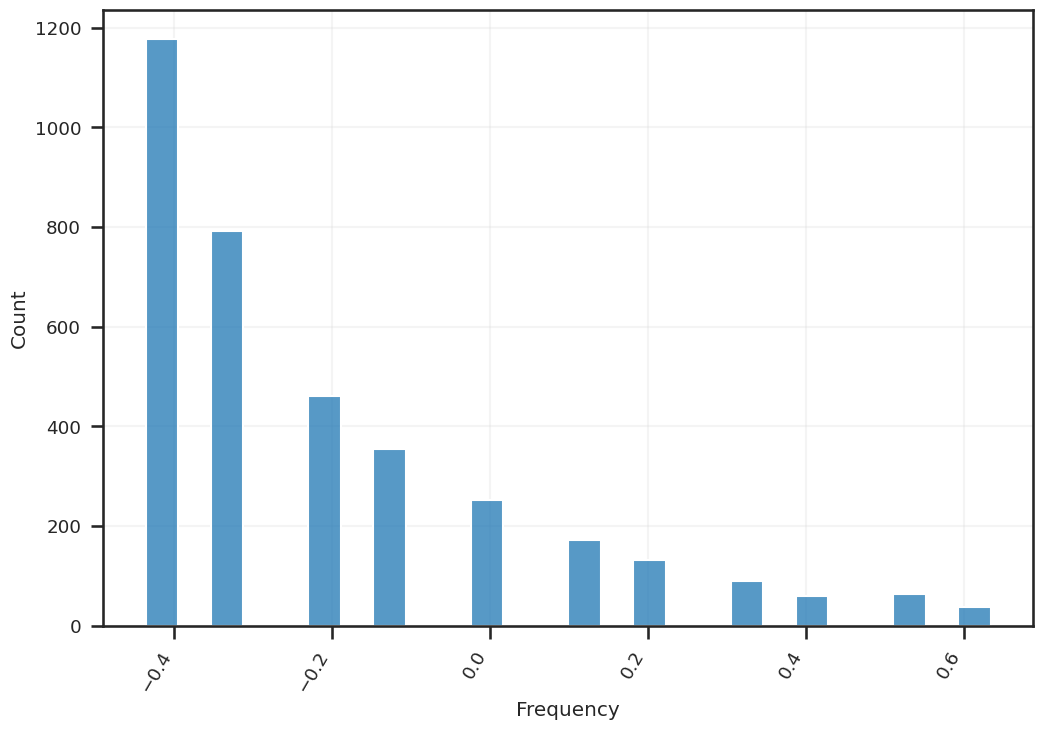

MonetaryValue:


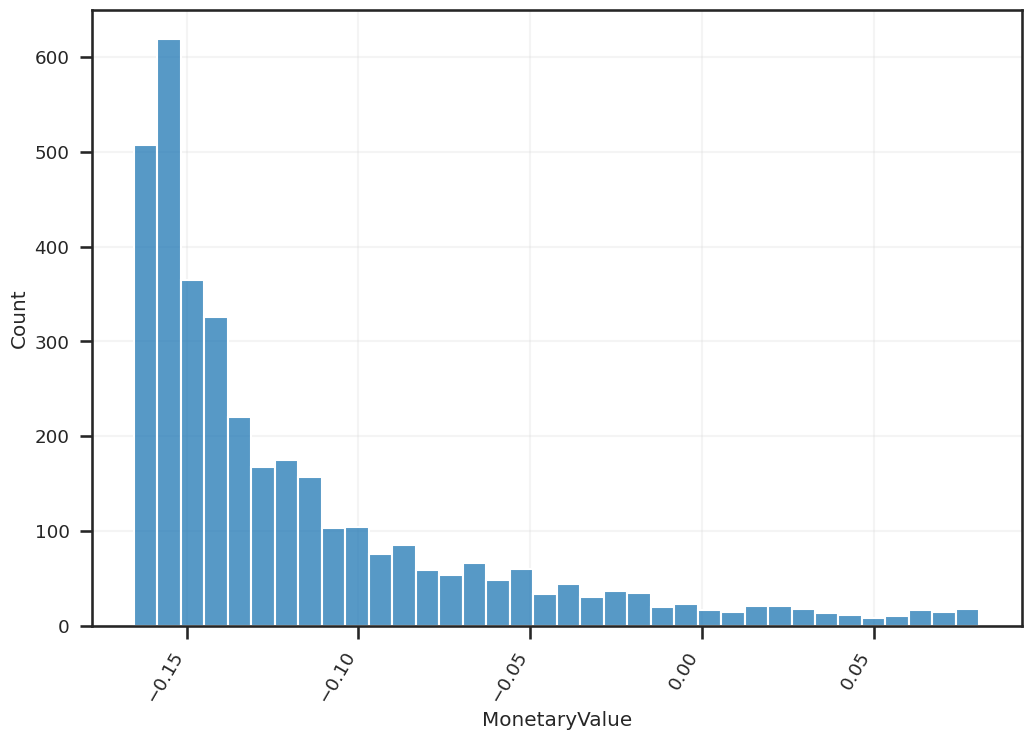

In [838]:
for coluna in colunas:
    print(f'{coluna}:')
    agrupando_perfis_de_clientes.gráfico_histplot(
        dataframe=df_rfv,
        coluna=coluna
)

### Clustering:



K-means:

O algoritmo K-means possui algumas vantagens distintas em relação a outros modelos de clusterização, como o DBSCAN, a hierarquia e o Mean Shift. Aqui estão algumas vantagens do K-means:

- Simplicidade: O K-means é um algoritmo de clusterização relativamente simples de entender e implementar. Ele é baseado no conceito de centróides e cálculos de distância.

- Eficiência computacional: O K-means é um algoritmo eficiente e escalável, especialmente para grandes conjuntos de dados. Sua complexidade computacional é linear em relação ao número de pontos de dados e ao número de clusters.

- Interpretabilidade: O resultado do K-means é facilmente interpretável, uma vez que cada ponto de dados é atribuído a um cluster específico. Isso permite uma compreensão intuitiva das estruturas e padrões encontrados nos dados.

- Flexibilidade: O K-means pode ser usado com diferentes métricas de distância e funciona bem com dados numéricos contínuos. Ele também pode ser adaptado para lidar com dados categóricos por meio de técnicas de codificação apropriadas.

- Escalabilidade: O K-means é adequado para grandes conjuntos de dados, pois seu desempenho não é afetado pelo aumento do número de observações. Isso o torna útil em cenários onde há um grande número de dados a serem clusterizados.

No entanto, é importante ressaltar que cada algoritmo de clusterização tem suas próprias vantagens e desvantagens.


In [839]:
modelo = KMeans()

In [840]:
x = df_rfv[colunas]

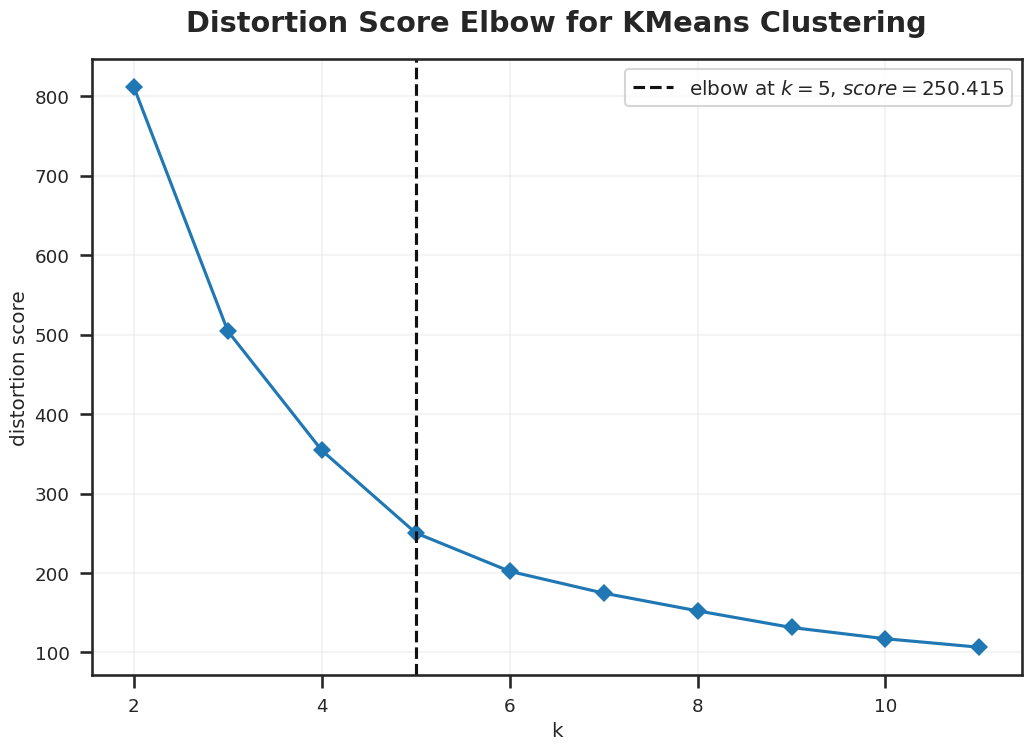

In [841]:
agrupando_perfis_de_clientes.gráfico_kelbow_visualizer(
    modelo=modelo,
    x=x,
    k=11
);

Criando os clusters:

In [842]:
modelo = KMeans(n_clusters=6, init='k-means++', random_state=37)

In [843]:
centroids, labels, inertia, predict = agrupando_perfis_de_clientes.clustering_k_means(
    model=modelo,
    x=x
)

Visualizando os clusters:

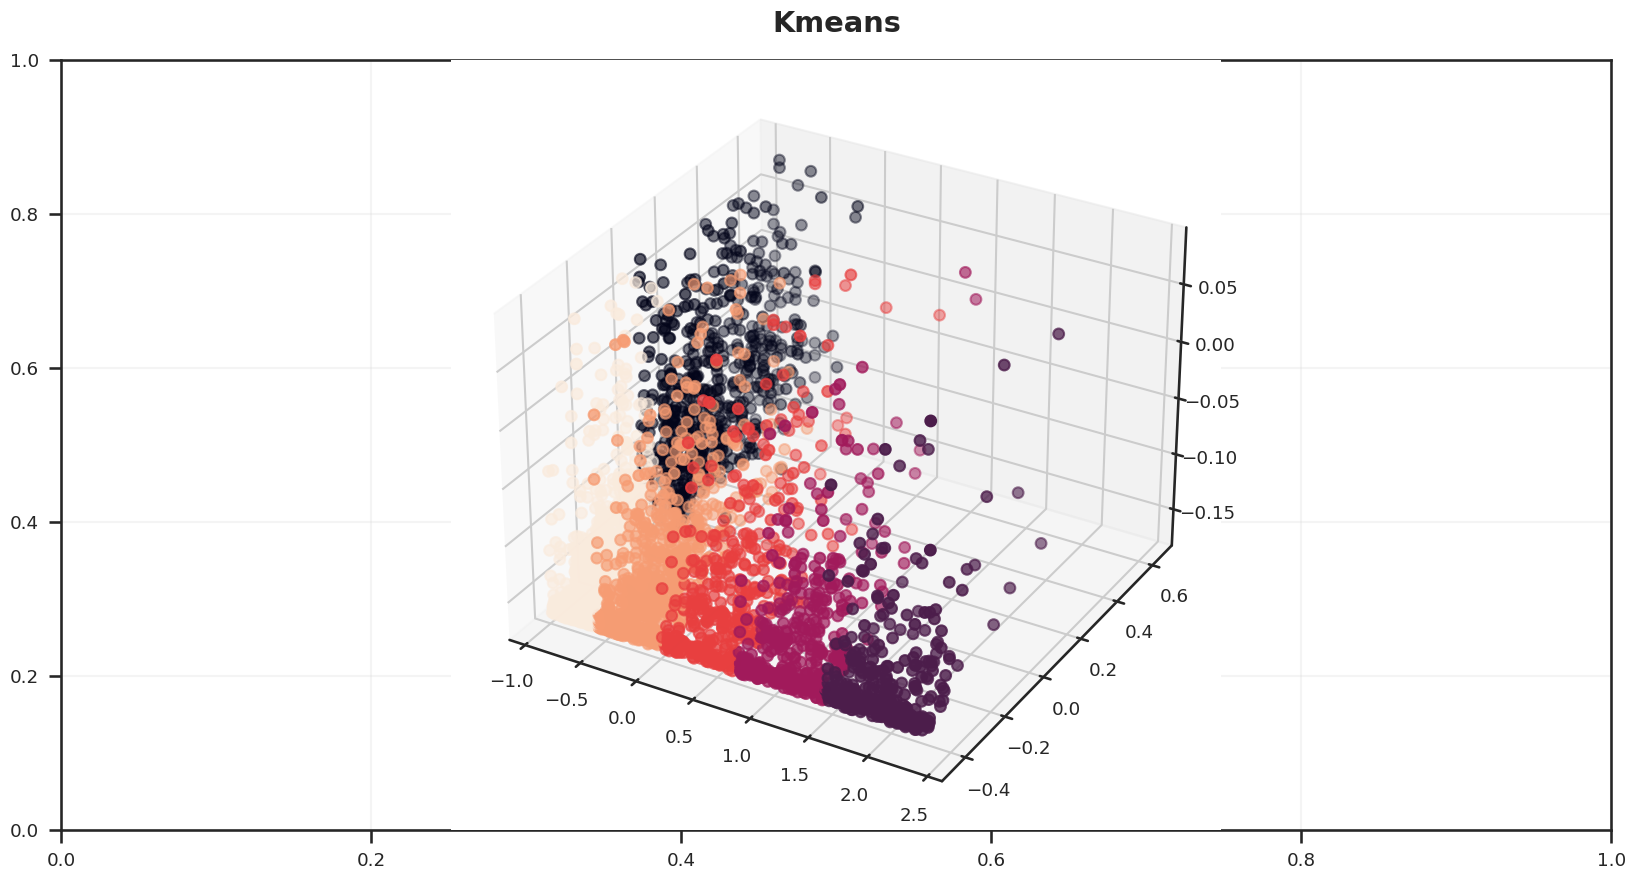

In [844]:
agrupando_perfis_de_clientes.gráfico_clusters_scatterplot3d(
    data=[df_rfv['Recency'],df_rfv['Frequency'],df_rfv['MonetaryValue']],
    labels=labels,
    figsize=(20,10),
    titulo='Kmeans'
)

In [845]:
agrupando_perfis_de_clientes.gráfico_clusters_scatterplot3d_interativo(
    data=[df_rfv['Recency'],df_rfv['Frequency'],df_rfv['MonetaryValue']],
    labels=labels,
    figsize=(500,500),
    titulo='Kmeans'
)